## Face mask detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import pathlib
from matplotlib.colors import Normalize

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNetV2

In [2]:
data_dir = "../dataset"
batch_size = 32

data_dir = pathlib.Path(data_dir)
IMG_SIZE = 256

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=batch_size,
  image_size=(IMG_SIZE,IMG_SIZE))

Found 1376 files belonging to 2 classes.
Using 1101 files for training.


In [4]:
train_ds.class_names

['with_mask', 'without_mask']

In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size,
  image_size=(IMG_SIZE,IMG_SIZE))

Found 1376 files belonging to 2 classes.
Using 275 files for validation.


In [6]:
train_np = train_ds.as_numpy_iterator()

### Todo

* Create a grid to show 9 images
* Make the images random
* Show classes below the image


(array([[[[ 36.296875 ,  24.296875 ,  36.296875 ],
         [ 38.373573 ,  26.373573 ,  38.373573 ],
         [ 41.010292 ,  29.010292 ,  41.010292 ],
         ...,
         [139.06604  , 115.06604  , 103.06604  ],
         [139.6455   , 115.64549  , 103.64549  ],
         [140.70508  , 116.70508  , 104.70508  ]],

        [[ 43.33203  ,  31.332031 ,  43.33203  ],
         [ 40.40811  ,  28.408112 ,  40.40811  ],
         [ 37.808254 ,  25.808254 ,  37.808254 ],
         ...,
         [157.81355  , 133.81355  , 122.03621  ],
         [158.99907  , 134.99907  , 123.12649  ],
         [158.10938  , 134.10938  , 122.109375 ]],

        [[ 37.44336  ,  25.44336  ,  37.44336  ],
         [ 39.01262  ,  27.012619 ,  39.01262  ],
         [ 41.20669  ,  29.206692 ,  41.20669  ],
         ...,
         [144.19443  , 120.194435 , 110.194435 ],
         [148.21127  , 124.21127  , 113.355804 ],
         [149.88672  , 125.88672  , 113.88672  ]],

        ...,

        [[ 41.308594 ,  26.453125 ,  

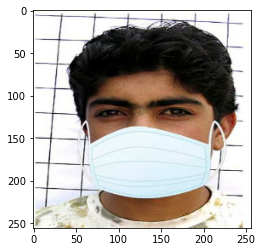

In [9]:
count = 0;
for element in train_np:
    plt.imshow(element[0][1]/255)
    print(element[0:10])
    count+=1
    break
    if count > 1:
        break

In [8]:
def prepare_dataset(path,label):
    x_train=[]
    y_train=[]
    all_images_path=glob.glob(path+'/*.jpg')
    for img_path in all_images_path :
            img=load_img(img_path, target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            x_train.append(img)
            y_train.append(label)
    return np.array(x_train),np.array(y_train)

In [9]:
local_weights_file = './inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [2]:
pre_trained_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

NameError: name 'IMG_SIZE' is not defined

In [11]:
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False

In [12]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(1, activation='sigmoid')(x)  


last layer output shape:  (None, 14, 14, 768)


In [14]:
model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [15]:
history=model.fit(train_ds,epochs=100,validation_data=val_ds)

Epoch 1/100
35/35 [==============================] - 101s 3s/step - loss: 23.6167 - acc: 0.5114 - val_loss: 0.6932 - val_acc: 0.4691
Epoch 2/100
35/35 [==============================] - 98s 3s/step - loss: 0.6925 - acc: 0.5068 - val_loss: 0.6932 - val_acc: 0.4691
Epoch 3/100
35/35 [==============================] - 91s 3s/step - loss: 0.7682 - acc: 0.5041 - val_loss: 0.6932 - val_acc: 0.4691
Epoch 4/100
35/35 [==============================] - 100s 3s/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6932 - val_acc: 0.4691
Epoch 5/100
35/35 [==============================] - 96s 3s/step - loss: 0.7083 - acc: 0.5050 - val_loss: 0.6932 - val_acc: 0.4691
Epoch 6/100
35/35 [==============================] - 98s 3s/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6932 - val_acc: 0.4691
Epoch 7/100
35/35 [==============================] - 101s 3s/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6932 - val_acc: 0.4691
Epoch 8/100
35/35 [==============================] - 104s 3s/step - loss: 0.693

KeyboardInterrupt: 